In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def finite_diff(f, x, eps=1e-6):
    
    f_x = f(x)
    
    if (len(x.shape) == 1):
        Jac_FD = np.zeros((f_x.size, x.size))
        for j in range(x.size):
            e_j = np.zeros(x.size)
            e_j[j]=1
            Jac_FD[:,j] = (f(x + eps*e_j) - f(x - eps*e_j)) / (2*eps)
        return Jac_FD
    
    elif (len(x.shape) == 2):
        Jac_FD = np.zeros((f_x.size, x.shape[0], x.shape[1]))
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                e_ij = np.zeros(x.shape)
                e_ij[i,j]=1
                Jac_FD[:,i,j] = (f(x + eps*e_ij) - f_x) / eps
        return Jac_FD
            
    else: print("Pb dimension")
    
def vjp_finite_diff(f,x,u, eps=1e-6):
    Jac=finite_diff(f, x, eps)
    
    if (len(Jac.shape) == 2):
        return Jac.T@u
    
    elif (len(Jac.shape) == 3):
        shape = Jac.shape
        Jac = Jac.reshape(shape[0], -1)
        return u.dot(Jac).reshape(shape[1:])
    
    else: print("Pb dimension")

# Question 1

In [3]:
def dot(W, x):
    value = np.dot(W, x)

    def vjp(u):
        return np.outer(u, x), W.T.dot(u)

    return value, vjp

In [4]:
n=5
p=2

W=np.random.randn(n,p)
x=np.random.randn(p)
u=np.random.randn(n)

value, vjp = dot(W, x)
print("function value: ",value)
print("VJP: ",vjp(u)[0])
print("VJP(fd): ",vjp_finite_diff(lambda W: dot(W,x)[0],W,u))
print("VJP: ",vjp(u)[1])
print("VJP(fd): ",vjp_finite_diff(lambda x: dot(W,x)[0],x,u))

function value:  [ 0.48714367  2.61599474  6.43110642 -0.39817037 -2.73198558]
VJP:  [[ 1.71935752  1.3226641 ]
 [ 0.47362568  0.36434986]
 [ 0.01798001  0.01383163]
 [-1.2816889  -0.9859752 ]
 [ 0.47078944  0.362168  ]]
VJP(fd):  [[ 1.71935752  1.3226641 ]
 [ 0.47362568  0.36434986]
 [ 0.01798001  0.01383163]
 [-1.2816889  -0.9859752 ]
 [ 0.47078944  0.362168  ]]
VJP:  [ 0.76381997 -0.41385307]
VJP(fd):  [ 0.76381997 -0.41385307]


In [5]:
def relu(x):
    value = np.maximum(x, 0)

    def vjp(u):
        #Jac = np.zeros((x.size,x.size))
        #Jac[x>0,x>0] = 1
        #vjp_wrt_x = Jac.T.dot(u)
        v = np.zeros(x.size)
        v[x>0] = 1
        vjp_wrt_x = u*v
        return vjp_wrt_x,
    return value, vjp

# Question 2

In [6]:
def mlp2(x, W1, W2):
    a,vjp_dot1 = dot(W1,x)
    b,vjp_relu1 = relu(a)
    c,vjp_dot2 = dot(W2,b)
    value,vjp_relu2 = relu(c)

    def vjp(u):
        vjp_wrt_x, = vjp_relu2(u)
        vjp_wrt_W2, vjp_wrt_x = vjp_dot2(vjp_wrt_x)
        vjp_wrt_x, = vjp_relu1(vjp_wrt_x)
        vjp_wrt_W1, vjp_wrt_x = vjp_dot1(vjp_wrt_x)
        return vjp_wrt_x, vjp_wrt_W1, vjp_wrt_W2

    return value, vjp

# Question 3

In [7]:
def squared_loss(y_pred, y):
    residual = y_pred - y
    
    def vjp(u):
        vjp_y_pred = u*(y_pred - y).T
        vjp_y = - vjp_y_pred
        return vjp_y_pred, vjp_y

    value = 0.5 * np.sum(residual ** 2)
    return np.array([value]), vjp

# Question 4

In [8]:
def loss(x, y, W1, W2):
    y_pred, vpj_mlp = mlp2(x, W1, W2)
    value, vjp_sql = squared_loss(y_pred,y)
    
    def vjp(u):
        vjp_wrt_x, vjp_wrt_y = vjp_sql(u)
        vjp_wrt_x, vjp_wrt_W1, vjp_wrt_W2 = vpj_mlp(vjp_wrt_x)
        return vjp_wrt_x, vjp_wrt_y, vjp_wrt_W1, vjp_wrt_W2
    
    return value, vjp

In [9]:
d=3
p=2

W1=np.random.randn(d,p)
W2=np.random.randn(1,d)
y=np.random.rand(1)
x=np.random.randn(p)

#Verif: error == 0: ok
#n=5
#W1=np.eye(n,n)
#W2=np.eye(n,n)
#y=np.random.rand(n)
#x=y

u=np.random.randn(1)

value, vjp = loss(x, y, W1, W2)

print("function value: ", 2*value/n)

error=np.linalg.norm(vjp(u)[0]-vjp_finite_diff(lambda x: loss(x, y, W1, W2)[0],x,u,eps=1e-8))
if error<1e-5: print("VJP wrt x is OK ")
else: print("VJP wrt x is NOT OK ")
error=np.linalg.norm(vjp(u)[1]-vjp_finite_diff(lambda y: loss(x, y, W1, W2)[0],y,u,eps=1e-8))
if error<1e-5: print("VJP wrt y is OK ")
else: print("VJP wrt y is NOT OK ")
error=np.linalg.norm(vjp(u)[2]-vjp_finite_diff(lambda W1: loss(x, y, W1, W2)[0],W1,u,eps=1e-8))
if (error<1e-1): print("VJP wrt",0,"th matrix is OK")
else: print("VJP wrt",0,"th matrix is NOT OK")
error=np.linalg.norm(vjp(u)[3]-vjp_finite_diff(lambda W2: loss(x, y, W1, W2)[0],W2,u,eps=1e-8))
if (error<1e-1): print("VJP wrt",1,"th matrix is OK")
else: print("VJP wrt",1,"th matrix is NOT OK")

function value:  [0.04970983]
VJP wrt x is OK 
VJP wrt y is OK 
VJP wrt 0 th matrix is OK
VJP wrt 1 th matrix is OK


# Question 5

In [10]:
def mlp_relu(x, param):
    n_layers=len(param)
    value = x
    vjp_wrt_W=[None]*n_layers
    vjp_dot=[None]*n_layers 
    vjp_relu=[None]*(n_layers-1)

    for layer in range(n_layers-1):
        value,vjp_dot[layer] = dot(param[layer],value)
        value,vjp_relu[layer] = relu(value)
        
    value,vjp_dot[n_layers-1] = dot(param[n_layers-1],value)   

        
    def vjp(u):
        vjp_wrt_x=u
        vjp_wrt_W[n_layers-1], vjp_wrt_x = vjp_dot[n_layers-1](vjp_wrt_x)
        for layer in range(1,n_layers):
            vjp_wrt_x, = vjp_relu[n_layers-layer-1](vjp_wrt_x)
            vjp_wrt_W[n_layers-layer-1], vjp_wrt_x = vjp_dot[n_layers-layer-1](vjp_wrt_x)
        
        return vjp_wrt_x, vjp_wrt_W
    return value, vjp

In [11]:
def loss_MLP(x, y, param):
    y_pred, vpj_mlp = mlp_relu(x, param)
    value, vjp_sql = squared_loss(y_pred,y)
        
    def vjp(u):
        vjp_wrt_x, vjp_wrt_y = vjp_sql(u)
        vjp_wrt_x, vjp_wrt_W = vpj_mlp(vjp_wrt_x)
        return vjp_wrt_x, vjp_wrt_y, vjp_wrt_W
    
    return value, vjp

In [12]:
p=9
d=5

y=np.random.rand(1)
x=np.random.randn(p)

n_layers=5

param=[None]*n_layers
d2=p
for layer in range(n_layers-1):
    d1=np.random.randint(5,12)
    #d1=d
    param[layer]=np.random.randn(d1,d2)
    d2=d1
    print(param[layer].shape)
param[-1]=np.random.randn(1,d2)
print(param[-1].shape)

(6, 9)
(9, 6)
(10, 9)
(6, 10)
(1, 6)


In [13]:
value, vjp = loss_MLP(x, y, param)

print("function value: ", 2*value/n)

u=np.random.randn(1)
error=np.linalg.norm(vjp(u)[0]-vjp_finite_diff(lambda x: loss_MLP(x, y, param)[0],x,u))
if error<1e-5: print("VJP wrt x is OK ")
else: print("VJP wrt x is NOT OK ")
    
error=np.linalg.norm(vjp(u)[1]-vjp_finite_diff(lambda y: loss_MLP(x, y, param)[0],y,u))
if error<1e-5: print("VJP wrt y is OK ")
else: print("VJP wrt y is NOT OK ")

for layer in range(n_layers):
    jac_wrt_W_i=vjp(u)[2][layer]
    def f(W_i):
        param_=list(param)
        param_[layer]=W_i
        return loss_MLP(x, y ,param_)[0]
    
    jac_wrt_W_i_FD=vjp_finite_diff(f,param[layer],u,eps=1e-6)
    
    error=np.linalg.norm(jac_wrt_W_i-jac_wrt_W_i_FD)
    if (error<1e-1): print("VJP wrt",layer,"th matrix is OK")
    else: print("VJP wrt",layer,"th matrix is NOT OK")
    #print(jac_wrt_W_i)

function value:  [23.61998079]
VJP wrt x is OK 
VJP wrt y is OK 
VJP wrt 0 th matrix is OK
VJP wrt 1 th matrix is OK
VJP wrt 2 th matrix is OK
VJP wrt 3 th matrix is OK
VJP wrt 4 th matrix is OK


# Question 6

On va utilisé notre jeu de donnée, qui contient 173 observations et 9 variables explicatives. On va split
nos données en 80/20 : 138 data dans notre train data set et 35 dans notre test data set. Initialement,
nos variables réponses étaient des scores de 0 à 100. L’utilisation de la fonction d’activation ReLu sur
le dernier layer semblait bien indiquée. Cependant, on a recentré nos données, elles peuvent donc
prendre des valeurs négatives. On n’utilisera donc aucune fonction d’activation sur le dernier layer.

In [14]:
from utils import datagen
from utils import datatreat

In [15]:
np.random.seed(1)

In [16]:
A_,y_ = datagen()
n,p,n_train,n_test,A,y,A_test,y_test = datatreat(A_,y_,0.8)

Number of obs: 173
n train: 138
n test: 35
Number of explicative variables: 9


In [17]:
def eval_loss_MLP(x, y, param):
    n_layers=len(param)
    n=np.array([y]).size
    y_pred=x.T
    for layer in range(n_layers-1): y_pred = np.maximum(param[layer]@y_pred,0)
    y_pred = param[n_layers-1]@y_pred
    return np.linalg.norm(y_pred-y)**2/n

Pour commencer, afin de vérifier notre implémentation, on va construire un MLP avec un unique
layer et un neuron, sans fonction d’activation. On est donc dans le cadre d’une régression linéaire
multiple. C’est un contexte pratique, car on a une idée des résultats attendus. En effet, comme on
peut le voir sur le graphe ci-dessous, notre train loss va tendre vers la train loss minimale, i.e. celle
obtenue avec l’estimateur OLS. La test loss, va elle aussi mécaniquement tendre vers la test loss
utilisant l’estimateur OLS obtenu sur l’échantillon train.

In [18]:
N_epoch=300
tau=0.001

n_layers=1
n_neuron=np.concatenate(([p],[1]))


W0=[]
for i in range(1,n_layers+1): W0.append(np.random.randn(n_neuron[i],n_neuron[i-1]))

W=[W0]


for layer in range(n_layers): print(W0[layer].shape)
    
error_train = np.ones(N_epoch)*eval_loss_MLP(A, y, W0)
error_test = np.ones(N_epoch)*eval_loss_MLP(A_test, y_test, W0)
error_train_min = np.ones(N_epoch)*eval_loss_MLP(A, y, W0)
error_test_min = np.ones(N_epoch)*eval_loss_MLP(A_test, y_test, W0)

print(error_train[0])
print(error_test[0])

(1, 9)
147.73782686212516
121.94867567938199


In [19]:
for i in range(1,N_epoch*n_train):
    ind=np.random.randint(0, n_train)
    
    trash, vjp = loss_MLP(A[ind], y[ind], W[i-1])
    Jac=vjp(1)[2]
    
    W.append([None]*n_layers)
    
    for layer in range(0,n_layers): W[i][layer] = W[i-1][layer] - tau*Jac[layer]
           
    if(i%n_train==0):
        ind_i=int(i//n_train)
        error_train[ind_i] = eval_loss_MLP(A, y, W[i])
        error_test[ind_i] = eval_loss_MLP(A_test, y_test, W[i])
        
        new_best = error_train_min[ind_i-1] > eval_loss_MLP(A, y, W[i])
        error_train_min[ind_i] = eval_loss_MLP(A, y, W[i]) if (new_best) else error_train_min[ind_i-1]
        error_test_min[ind_i] = eval_loss_MLP(A_test, y_test, W[i]) if (new_best) else error_test_min[ind_i-1]

        print("Error train:", ind_i,": ", error_train[ind_i])
        print("Error test:", ind_i,": ", error_test[ind_i])
        print("-"*80)

Error train: 1 :  41.56418804099657
Error test: 1 :  34.79620078114897
--------------------------------------------------------------------------------
Error train: 2 :  15.485876513304527
Error test: 2 :  12.607647631468549
--------------------------------------------------------------------------------
Error train: 3 :  9.741119325636419
Error test: 3 :  7.429621504129159
--------------------------------------------------------------------------------
Error train: 4 :  8.332572330732763
Error test: 4 :  6.22256370495368
--------------------------------------------------------------------------------
Error train: 5 :  7.685723744988231
Error test: 5 :  5.699122426632139
--------------------------------------------------------------------------------
Error train: 6 :  7.278224150334162
Error test: 6 :  5.404378581366747
--------------------------------------------------------------------------------
Error train: 7 :  7.058105509513263
Error test: 7 :  5.3592995800456995
---------------

Error train: 63 :  4.727331595184044
Error test: 63 :  5.257104052880909
--------------------------------------------------------------------------------
Error train: 64 :  4.7215434308919555
Error test: 64 :  5.246709835977417
--------------------------------------------------------------------------------
Error train: 65 :  4.71527261451073
Error test: 65 :  5.265765015152705
--------------------------------------------------------------------------------
Error train: 66 :  4.712322221637361
Error test: 66 :  5.310853447007584
--------------------------------------------------------------------------------
Error train: 67 :  4.72903027503085
Error test: 67 :  5.35674093903669
--------------------------------------------------------------------------------
Error train: 68 :  4.709541313086693
Error test: 68 :  5.327915788087762
--------------------------------------------------------------------------------
Error train: 69 :  4.7331250060601295
Error test: 69 :  5.318282145581549
----

Error train: 117 :  4.699166346201724
Error test: 117 :  5.4785331155675445
--------------------------------------------------------------------------------
Error train: 118 :  4.702948809980893
Error test: 118 :  5.4524001103028885
--------------------------------------------------------------------------------
Error train: 119 :  4.69494676073844
Error test: 119 :  5.446131472260581
--------------------------------------------------------------------------------
Error train: 120 :  4.722344436159743
Error test: 120 :  5.517082124643479
--------------------------------------------------------------------------------
Error train: 121 :  4.713828428083667
Error test: 121 :  5.491444584698288
--------------------------------------------------------------------------------
Error train: 122 :  4.696260291553761
Error test: 122 :  5.453052564983408
--------------------------------------------------------------------------------
Error train: 123 :  4.698065439218987
Error test: 123 :  5.4161

Error train: 171 :  4.707969487344726
Error test: 171 :  5.5422433407414635
--------------------------------------------------------------------------------
Error train: 172 :  4.717021907378632
Error test: 172 :  5.559657761353847
--------------------------------------------------------------------------------
Error train: 173 :  4.701078808090149
Error test: 173 :  5.586013602652006
--------------------------------------------------------------------------------
Error train: 174 :  4.699577717519757
Error test: 174 :  5.551544722225908
--------------------------------------------------------------------------------
Error train: 175 :  4.702446666251923
Error test: 175 :  5.550618368076556
--------------------------------------------------------------------------------
Error train: 176 :  4.712279084312979
Error test: 176 :  5.5864979128040595
--------------------------------------------------------------------------------
Error train: 177 :  4.702232249256814
Error test: 177 :  5.547

Error train: 225 :  4.715605327962548
Error test: 225 :  5.699524574650736
--------------------------------------------------------------------------------
Error train: 226 :  4.733585371379322
Error test: 226 :  5.747497859936104
--------------------------------------------------------------------------------
Error train: 227 :  4.732390554241964
Error test: 227 :  5.758676883763987
--------------------------------------------------------------------------------
Error train: 228 :  4.7158639631877435
Error test: 228 :  5.751525626984899
--------------------------------------------------------------------------------
Error train: 229 :  4.70601504675722
Error test: 229 :  5.708913692675307
--------------------------------------------------------------------------------
Error train: 230 :  4.724115690397799
Error test: 230 :  5.746487120012228
--------------------------------------------------------------------------------
Error train: 231 :  4.7056556535595515
Error test: 231 :  5.7086

Error train: 284 :  4.722239256096386
Error test: 284 :  5.726682110792648
--------------------------------------------------------------------------------
Error train: 285 :  4.728124001222716
Error test: 285 :  5.71782113959292
--------------------------------------------------------------------------------
Error train: 286 :  4.783311144871412
Error test: 286 :  5.723148097689086
--------------------------------------------------------------------------------
Error train: 287 :  4.7252461487182575
Error test: 287 :  5.685217749280658
--------------------------------------------------------------------------------
Error train: 288 :  4.720102009525611
Error test: 288 :  5.64141678994108
--------------------------------------------------------------------------------
Error train: 289 :  4.71815039824274
Error test: 289 :  5.632939659933048
--------------------------------------------------------------------------------
Error train: 290 :  4.720846890982133
Error test: 290 :  5.6275114

In [20]:
W_star=np.linalg.inv(A.T@A)@A.T@y
print("Train error for OLS: ", np.linalg.norm(W_star@A.T-y)**2/n_train)
print("Train error for MLP: ",error_train_min[-1])
print()
print("Test error for OLS: ", np.linalg.norm(W_star@A_test.T-y_test)**2/n_test)
print("Test error for MLP: ",error_test_min[-1])

Train error for OLS:  4.687344092905545
Train error for MLP:  4.690527502874717

Test error for OLS:  5.5598617842713765
Test error for MLP:  5.492301327008453


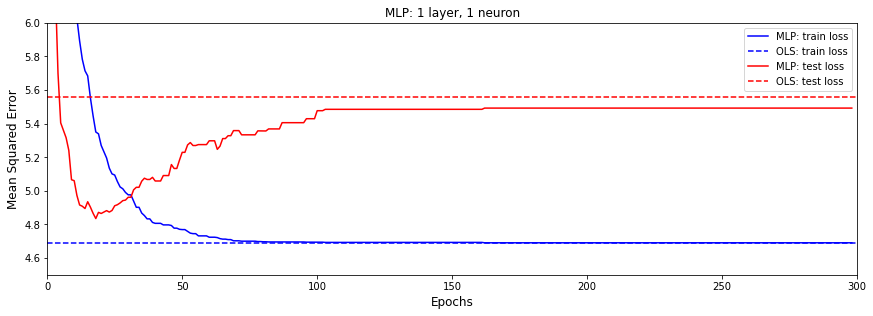

In [21]:
plt.plot(10**np.log10(error_train_min[1:]), color='blue', label='MLP: train loss')
plt.axhline(y = np.linalg.norm(W_star@A.T-y)**2/n_train, color = 'blue', linestyle = '--', label='OLS: train loss')
plt.plot(10**np.log10(error_test_min[1:]), color='red', label='MLP: test loss')
plt.axhline(y = np.linalg.norm(W_star@A_test.T-y_test)**2/n_test, color = 'red', linestyle = '--', label='OLS: test loss')
plt.xlim(0,N_epoch)
plt.ylim(4.5,6)
plt.legend();
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Mean Squared Error",fontsize=12)
plt.title("MLP: 1 layer, 1 neuron",fontsize=12)
plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)

On remarque que dans les 50 premières epochs, la train et test loss se croisent, les modèles cor-
respondant au voisinage de cette intersection, pourraient être de bon modèle en termes d’arbitrage
biais/variance.
On va maintenant complexifier notre MLP en rajoutant un layer, constitué de 24 neurons. Notre pro-
blème d’optimisation semble maintenant complètement soluble. En effet, on observe sur le graphe ci-
dessous, que la train loss converge vers 0. Cependant d’un point de vue data scientist, nous sommes
évidemment complètement en train d’over fit, ce qui se retranscrit par une augmentation mécanique
de la test loss.

In [22]:
N_epoch=1500
tau=0.001

#n_layers=4
#n_neuron=np.concatenate(([p],2**np.array([4,5,4]),[1]))

n_layers=2
n_neuron=np.concatenate(([p],2**np.array([4]),[1]))




W0=[]
for i in range(1,n_layers+1): W0.append(np.random.randn(n_neuron[i],n_neuron[i-1]))

W=[W0]


for layer in range(n_layers): print(W0[layer].shape)
    
error_train = np.ones(N_epoch)*eval_loss_MLP(A, y, W0)
error_test = np.ones(N_epoch)*eval_loss_MLP(A_test, y_test, W0)
error_train_min = np.ones(N_epoch)*eval_loss_MLP(A, y, W0)
error_test_min = np.ones(N_epoch)*eval_loss_MLP(A_test, y_test, W0)

print(error_train[0])
print(error_test[0])

(16, 9)
(1, 16)
373.12869538125847
237.5594838605426


In [23]:
for i in range(1,N_epoch*n_train):
    ind=np.random.randint(0, n_train)
    
    trash, vjp = loss_MLP(A[ind], y[ind], W[i-1])
    Jac=vjp(1)[2]
    
    W.append([None]*n_layers)
    
    for layer in range(0,n_layers): W[i][layer] = W[i-1][layer] - tau*Jac[layer]
           
    if(i%n_train==0):
        ind_i=int(i//n_train)
        error_train[ind_i] = eval_loss_MLP(A, y, W[i])
        error_test[ind_i] = eval_loss_MLP(A_test, y_test, W[i])
        
        new_best = error_train_min[ind_i-1] > eval_loss_MLP(A, y, W[i])
        error_train_min[ind_i] = eval_loss_MLP(A, y, W[i]) if (new_best) else error_train_min[ind_i-1]
        error_test_min[ind_i] = eval_loss_MLP(A_test, y_test, W[i]) if (new_best) else error_test_min[ind_i-1]

        print("Error train:", ind_i,": ", error_train[ind_i])
        print("Error test:", ind_i,": ", error_test[ind_i])
        print("-"*80)

Error train: 1 :  20.258082415500166
Error test: 1 :  18.56488575176659
--------------------------------------------------------------------------------
Error train: 2 :  10.903247845912722
Error test: 2 :  11.351663485044583
--------------------------------------------------------------------------------
Error train: 3 :  12.56792320008542
Error test: 3 :  15.832060678832386
--------------------------------------------------------------------------------
Error train: 4 :  7.866506062240955
Error test: 4 :  9.386985570977528
--------------------------------------------------------------------------------
Error train: 5 :  6.8383786493957075
Error test: 5 :  8.17234210934964
--------------------------------------------------------------------------------
Error train: 6 :  6.544341485381662
Error test: 6 :  7.06370109255196
--------------------------------------------------------------------------------
Error train: 7 :  6.028468496383656
Error test: 7 :  7.451108723624998
--------------

Error train: 62 :  3.3643397296272317
Error test: 62 :  5.209873486006278
--------------------------------------------------------------------------------
Error train: 63 :  3.8699818555743857
Error test: 63 :  5.702388825263388
--------------------------------------------------------------------------------
Error train: 64 :  3.3240726819499686
Error test: 64 :  5.233881654505694
--------------------------------------------------------------------------------
Error train: 65 :  3.3788031253047976
Error test: 65 :  5.231454395865228
--------------------------------------------------------------------------------
Error train: 66 :  3.305233508960759
Error test: 66 :  5.375079692323651
--------------------------------------------------------------------------------
Error train: 67 :  3.332026764036352
Error test: 67 :  5.608728050241586
--------------------------------------------------------------------------------
Error train: 68 :  3.378435957084934
Error test: 68 :  4.894518821483184

Error train: 115 :  3.315010644088407
Error test: 115 :  5.611756179297807
--------------------------------------------------------------------------------
Error train: 116 :  3.1617738893663385
Error test: 116 :  5.182042373718405
--------------------------------------------------------------------------------
Error train: 117 :  3.191955532799396
Error test: 117 :  5.44384455543028
--------------------------------------------------------------------------------
Error train: 118 :  3.2245307009082276
Error test: 118 :  5.222234195749431
--------------------------------------------------------------------------------
Error train: 119 :  3.5244772101877424
Error test: 119 :  5.831101040974917
--------------------------------------------------------------------------------
Error train: 120 :  3.1188866021296136
Error test: 120 :  5.600717942217287
--------------------------------------------------------------------------------
Error train: 121 :  3.2702093480081778
Error test: 121 :  6.1

Error train: 168 :  3.102407404827073
Error test: 168 :  6.357052975234376
--------------------------------------------------------------------------------
Error train: 169 :  3.145328032088577
Error test: 169 :  6.674303729963786
--------------------------------------------------------------------------------
Error train: 170 :  2.9635384930129236
Error test: 170 :  6.024704899898011
--------------------------------------------------------------------------------
Error train: 171 :  2.970164756468735
Error test: 171 :  5.916156546721962
--------------------------------------------------------------------------------
Error train: 172 :  3.2063912179115315
Error test: 172 :  5.448657133527836
--------------------------------------------------------------------------------
Error train: 173 :  2.9427093746023196
Error test: 173 :  5.916072583188347
--------------------------------------------------------------------------------
Error train: 174 :  2.9844164775036575
Error test: 174 :  6.2

Error train: 221 :  2.869700558595478
Error test: 221 :  5.645025684951397
--------------------------------------------------------------------------------
Error train: 222 :  3.398822593189372
Error test: 222 :  7.2259999324935755
--------------------------------------------------------------------------------
Error train: 223 :  2.945369877388603
Error test: 223 :  5.618814847593767
--------------------------------------------------------------------------------
Error train: 224 :  2.9908727731443836
Error test: 224 :  6.782215857361721
--------------------------------------------------------------------------------
Error train: 225 :  2.850329316668879
Error test: 225 :  6.150728306066032
--------------------------------------------------------------------------------
Error train: 226 :  3.184824440754779
Error test: 226 :  5.683783923595905
--------------------------------------------------------------------------------
Error train: 227 :  3.135338831381602
Error test: 227 :  5.395

Error train: 283 :  2.8114552622667905
Error test: 283 :  6.079492501634044
--------------------------------------------------------------------------------
Error train: 284 :  3.3266161373113694
Error test: 284 :  8.217343119420379
--------------------------------------------------------------------------------
Error train: 285 :  2.7971583820638743
Error test: 285 :  7.028148155254494
--------------------------------------------------------------------------------
Error train: 286 :  2.9140673089839195
Error test: 286 :  7.444973714045128
--------------------------------------------------------------------------------
Error train: 287 :  2.6522939937230423
Error test: 287 :  6.606592141133101
--------------------------------------------------------------------------------
Error train: 288 :  2.6965595446766883
Error test: 288 :  6.6199990912468465
--------------------------------------------------------------------------------
Error train: 289 :  2.8691395939178665
Error test: 289 : 

Error train: 347 :  3.118325430455461
Error test: 347 :  7.318884348501821
--------------------------------------------------------------------------------
Error train: 348 :  2.970331238559691
Error test: 348 :  6.739767664732995
--------------------------------------------------------------------------------
Error train: 349 :  2.5176602831833135
Error test: 349 :  6.903435164110767
--------------------------------------------------------------------------------
Error train: 350 :  2.574374371119994
Error test: 350 :  6.802512602911147
--------------------------------------------------------------------------------
Error train: 351 :  2.8715340083804826
Error test: 351 :  7.045223077726494
--------------------------------------------------------------------------------
Error train: 352 :  2.52421046447902
Error test: 352 :  7.4880853239223155
--------------------------------------------------------------------------------
Error train: 353 :  2.729317296846401
Error test: 353 :  6.539

Error train: 411 :  2.4839857587219423
Error test: 411 :  7.296850647118357
--------------------------------------------------------------------------------
Error train: 412 :  3.168774134855291
Error test: 412 :  8.792009387298931
--------------------------------------------------------------------------------
Error train: 413 :  2.605722296678411
Error test: 413 :  6.751103715357191
--------------------------------------------------------------------------------
Error train: 414 :  2.6671210540304227
Error test: 414 :  8.226344925880435
--------------------------------------------------------------------------------
Error train: 415 :  2.464473910095434
Error test: 415 :  7.410197380264174
--------------------------------------------------------------------------------
Error train: 416 :  2.4134357386574288
Error test: 416 :  7.513347322634925
--------------------------------------------------------------------------------
Error train: 417 :  2.4164475668239374
Error test: 417 :  7.9

Error train: 465 :  2.553341559952566
Error test: 465 :  7.598361454516649
--------------------------------------------------------------------------------
Error train: 466 :  2.43353069300121
Error test: 466 :  8.001047568415483
--------------------------------------------------------------------------------
Error train: 467 :  2.7681915981232144
Error test: 467 :  9.70651108895792
--------------------------------------------------------------------------------
Error train: 468 :  2.347302140535575
Error test: 468 :  7.874532295316593
--------------------------------------------------------------------------------
Error train: 469 :  2.5303433566763105
Error test: 469 :  8.279358793425681
--------------------------------------------------------------------------------
Error train: 470 :  2.3831003525466485
Error test: 470 :  7.811045090458886
--------------------------------------------------------------------------------
Error train: 471 :  2.3493652645115923
Error test: 471 :  7.745

Error train: 527 :  2.2187583017434966
Error test: 527 :  8.013203923278775
--------------------------------------------------------------------------------
Error train: 528 :  2.3830663696127217
Error test: 528 :  7.93508653159392
--------------------------------------------------------------------------------
Error train: 529 :  2.344927927759139
Error test: 529 :  7.797688443030859
--------------------------------------------------------------------------------
Error train: 530 :  2.242350077418959
Error test: 530 :  8.001322925407768
--------------------------------------------------------------------------------
Error train: 531 :  2.4742224882693176
Error test: 531 :  8.765227633622974
--------------------------------------------------------------------------------
Error train: 532 :  2.303157223365887
Error test: 532 :  8.184865756279837
--------------------------------------------------------------------------------
Error train: 533 :  2.240642709907404
Error test: 533 :  8.482

Error train: 592 :  3.9473711986400146
Error test: 592 :  9.919126656205767
--------------------------------------------------------------------------------
Error train: 593 :  2.547806513266025
Error test: 593 :  8.901957469005737
--------------------------------------------------------------------------------
Error train: 594 :  2.1872147524253336
Error test: 594 :  8.710481072843775
--------------------------------------------------------------------------------
Error train: 595 :  2.218743400566688
Error test: 595 :  9.057766404715892
--------------------------------------------------------------------------------
Error train: 596 :  2.2897531709715055
Error test: 596 :  9.12641321769793
--------------------------------------------------------------------------------
Error train: 597 :  2.2196519016440814
Error test: 597 :  8.905821676542278
--------------------------------------------------------------------------------
Error train: 598 :  2.166378603736398
Error test: 598 :  8.77

Error train: 656 :  2.0185303942118904
Error test: 656 :  8.953911916082632
--------------------------------------------------------------------------------
Error train: 657 :  2.287830804468635
Error test: 657 :  10.350541324817025
--------------------------------------------------------------------------------
Error train: 658 :  2.0693420059126795
Error test: 658 :  10.011513106226134
--------------------------------------------------------------------------------
Error train: 659 :  2.07929721364127
Error test: 659 :  9.419150488193694
--------------------------------------------------------------------------------
Error train: 660 :  1.9916339398070302
Error test: 660 :  9.666282000902564
--------------------------------------------------------------------------------
Error train: 661 :  2.352936321180792
Error test: 661 :  9.104614265958908
--------------------------------------------------------------------------------
Error train: 662 :  2.077829131183652
Error test: 662 :  9.6

Error train: 716 :  1.9510128904723978
Error test: 716 :  9.517090392129363
--------------------------------------------------------------------------------
Error train: 717 :  2.592420692258716
Error test: 717 :  9.110529426499566
--------------------------------------------------------------------------------
Error train: 718 :  2.0730941927608715
Error test: 718 :  9.293324157651668
--------------------------------------------------------------------------------
Error train: 719 :  2.200689688662497
Error test: 719 :  8.997386307200241
--------------------------------------------------------------------------------
Error train: 720 :  2.0486533725964646
Error test: 720 :  9.18564541562675
--------------------------------------------------------------------------------
Error train: 721 :  2.14941845642088
Error test: 721 :  9.01879740149173
--------------------------------------------------------------------------------
Error train: 722 :  2.221218760303785
Error test: 722 :  8.87929

Error train: 776 :  1.9459070719729226
Error test: 776 :  9.598548631658286
--------------------------------------------------------------------------------
Error train: 777 :  2.2283881737365325
Error test: 777 :  9.01829077473982
--------------------------------------------------------------------------------
Error train: 778 :  1.9089767358978904
Error test: 778 :  10.171126769879349
--------------------------------------------------------------------------------
Error train: 779 :  2.024506017117475
Error test: 779 :  10.270340314328458
--------------------------------------------------------------------------------
Error train: 780 :  2.0533386836251393
Error test: 780 :  9.590950606624288
--------------------------------------------------------------------------------
Error train: 781 :  1.949728177426549
Error test: 781 :  10.233109351015903
--------------------------------------------------------------------------------
Error train: 782 :  1.926555067303196
Error test: 782 :  9

Error train: 829 :  1.8354861723941833
Error test: 829 :  10.165538793276532
--------------------------------------------------------------------------------
Error train: 830 :  1.8966082482584286
Error test: 830 :  10.077147393719722
--------------------------------------------------------------------------------
Error train: 831 :  1.9126381038282703
Error test: 831 :  10.287632786866567
--------------------------------------------------------------------------------
Error train: 832 :  1.9573912071230966
Error test: 832 :  10.528039562532996
--------------------------------------------------------------------------------
Error train: 833 :  2.1852294951152373
Error test: 833 :  11.136664912253913
--------------------------------------------------------------------------------
Error train: 834 :  1.9571959295520378
Error test: 834 :  9.978846048178099
--------------------------------------------------------------------------------
Error train: 835 :  1.8785048281864556
Error test: 83

Error train: 893 :  2.068903286572529
Error test: 893 :  9.476130761311524
--------------------------------------------------------------------------------
Error train: 894 :  2.260271915279396
Error test: 894 :  11.151938910960407
--------------------------------------------------------------------------------
Error train: 895 :  1.8710320152011946
Error test: 895 :  10.060201146989614
--------------------------------------------------------------------------------
Error train: 896 :  1.8668907201196756
Error test: 896 :  10.282275288642307
--------------------------------------------------------------------------------
Error train: 897 :  1.838065217098408
Error test: 897 :  10.452456895238024
--------------------------------------------------------------------------------
Error train: 898 :  1.8168196121812055
Error test: 898 :  10.172579195824447
--------------------------------------------------------------------------------
Error train: 899 :  1.9279451901093179
Error test: 899 :

Error train: 956 :  1.8429567821287063
Error test: 956 :  10.332450697225932
--------------------------------------------------------------------------------
Error train: 957 :  1.915071006987491
Error test: 957 :  10.71381091013487
--------------------------------------------------------------------------------
Error train: 958 :  2.2212107078511227
Error test: 958 :  10.734380991692154
--------------------------------------------------------------------------------
Error train: 959 :  1.950894911125774
Error test: 959 :  10.070863405892725
--------------------------------------------------------------------------------
Error train: 960 :  2.015180253116089
Error test: 960 :  11.171475074578666
--------------------------------------------------------------------------------
Error train: 961 :  2.0192072285515605
Error test: 961 :  9.807857044346962
--------------------------------------------------------------------------------
Error train: 962 :  2.0620790238101425
Error test: 962 : 

Error train: 1019 :  1.9142902311694427
Error test: 1019 :  11.580665852675585
--------------------------------------------------------------------------------
Error train: 1020 :  1.8239482938990217
Error test: 1020 :  10.383069449846936
--------------------------------------------------------------------------------
Error train: 1021 :  1.84109527294118
Error test: 1021 :  10.325210912565124
--------------------------------------------------------------------------------
Error train: 1022 :  1.898550801703722
Error test: 1022 :  11.711641970323313
--------------------------------------------------------------------------------
Error train: 1023 :  1.7405093105596625
Error test: 1023 :  10.938734635551887
--------------------------------------------------------------------------------
Error train: 1024 :  1.784835251014217
Error test: 1024 :  10.64851482354759
--------------------------------------------------------------------------------
Error train: 1025 :  1.9407236949313507
Error

Error train: 1072 :  1.7568586255567675
Error test: 1072 :  10.971210920942712
--------------------------------------------------------------------------------
Error train: 1073 :  2.002506472933844
Error test: 1073 :  10.913475783350835
--------------------------------------------------------------------------------
Error train: 1074 :  1.863954078502997
Error test: 1074 :  12.077779350436453
--------------------------------------------------------------------------------
Error train: 1075 :  1.8501551208896487
Error test: 1075 :  11.15894499497805
--------------------------------------------------------------------------------
Error train: 1076 :  1.978031924931627
Error test: 1076 :  11.097528990305214
--------------------------------------------------------------------------------
Error train: 1077 :  1.7252951022538514
Error test: 1077 :  11.393613633032398
--------------------------------------------------------------------------------
Error train: 1078 :  1.787940418695715
Error

Error train: 1131 :  1.8663054123133418
Error test: 1131 :  10.54522046757417
--------------------------------------------------------------------------------
Error train: 1132 :  1.8106282286152997
Error test: 1132 :  10.54552937241362
--------------------------------------------------------------------------------
Error train: 1133 :  1.7463085110858452
Error test: 1133 :  10.837306122018292
--------------------------------------------------------------------------------
Error train: 1134 :  1.7131786939112867
Error test: 1134 :  10.967460451865039
--------------------------------------------------------------------------------
Error train: 1135 :  1.7542089542320887
Error test: 1135 :  10.653448324498072
--------------------------------------------------------------------------------
Error train: 1136 :  1.7109867434683295
Error test: 1136 :  11.142996990525026
--------------------------------------------------------------------------------
Error train: 1137 :  1.662253929883015
Err

Error train: 1193 :  1.728166112643103
Error test: 1193 :  12.24457327080723
--------------------------------------------------------------------------------
Error train: 1194 :  1.637890213352132
Error test: 1194 :  11.674105743044716
--------------------------------------------------------------------------------
Error train: 1195 :  1.6633328053633263
Error test: 1195 :  11.760199572792667
--------------------------------------------------------------------------------
Error train: 1196 :  1.6312533474589703
Error test: 1196 :  12.205644630107056
--------------------------------------------------------------------------------
Error train: 1197 :  1.6500960500611792
Error test: 1197 :  11.95994464037212
--------------------------------------------------------------------------------
Error train: 1198 :  1.7203654978030458
Error test: 1198 :  12.350546530785925
--------------------------------------------------------------------------------
Error train: 1199 :  1.651018259899461
Error

Error train: 1257 :  1.6420658483115562
Error test: 1257 :  12.863275998817308
--------------------------------------------------------------------------------
Error train: 1258 :  1.8635812406480186
Error test: 1258 :  12.348728819598074
--------------------------------------------------------------------------------
Error train: 1259 :  2.3459572565937936
Error test: 1259 :  12.311768459583238
--------------------------------------------------------------------------------
Error train: 1260 :  1.6304310662841177
Error test: 1260 :  12.523294286391613
--------------------------------------------------------------------------------
Error train: 1261 :  1.9033850062875934
Error test: 1261 :  13.133841064371133
--------------------------------------------------------------------------------
Error train: 1262 :  1.613749503627179
Error test: 1262 :  12.354379871331354
--------------------------------------------------------------------------------
Error train: 1263 :  1.6105356264594828
E

Error train: 1316 :  1.8434317752371976
Error test: 1316 :  12.830302547955569
--------------------------------------------------------------------------------
Error train: 1317 :  1.5957004066632894
Error test: 1317 :  14.062013499721436
--------------------------------------------------------------------------------
Error train: 1318 :  1.652204213960424
Error test: 1318 :  12.992560495523731
--------------------------------------------------------------------------------
Error train: 1319 :  1.5281266803818545
Error test: 1319 :  13.291262210721152
--------------------------------------------------------------------------------
Error train: 1320 :  1.9038407393007082
Error test: 1320 :  12.995911057368923
--------------------------------------------------------------------------------
Error train: 1321 :  1.5956977410650315
Error test: 1321 :  13.539505955415649
--------------------------------------------------------------------------------
Error train: 1322 :  1.5832208144013957
E

Error train: 1368 :  1.7316481968859005
Error test: 1368 :  13.315038110743345
--------------------------------------------------------------------------------
Error train: 1369 :  1.4921910657912005
Error test: 1369 :  14.492109294953664
--------------------------------------------------------------------------------
Error train: 1370 :  1.4368767897423047
Error test: 1370 :  13.57802397038727
--------------------------------------------------------------------------------
Error train: 1371 :  1.4923854240548684
Error test: 1371 :  14.464643754139908
--------------------------------------------------------------------------------
Error train: 1372 :  1.6632146924038234
Error test: 1372 :  15.2318286903454
--------------------------------------------------------------------------------
Error train: 1373 :  1.4679563463561363
Error test: 1373 :  14.32702766376753
--------------------------------------------------------------------------------
Error train: 1374 :  1.4734469029288293
Erro

Error train: 1433 :  1.3467394504654329
Error test: 1433 :  14.38252394955167
--------------------------------------------------------------------------------
Error train: 1434 :  1.4294023579870552
Error test: 1434 :  15.126471576663981
--------------------------------------------------------------------------------
Error train: 1435 :  1.4606369917757864
Error test: 1435 :  14.845733158450285
--------------------------------------------------------------------------------
Error train: 1436 :  1.4745342896249993
Error test: 1436 :  14.696809943662902
--------------------------------------------------------------------------------
Error train: 1437 :  1.341339663067212
Error test: 1437 :  14.784858601533042
--------------------------------------------------------------------------------
Error train: 1438 :  1.6382324514519917
Error test: 1438 :  14.260667833546313
--------------------------------------------------------------------------------
Error train: 1439 :  1.722817993863909
Err

Error train: 1485 :  1.3883057700814796
Error test: 1485 :  14.80061522002768
--------------------------------------------------------------------------------
Error train: 1486 :  1.5171176077530693
Error test: 1486 :  16.041161968455587
--------------------------------------------------------------------------------
Error train: 1487 :  1.3415704437438711
Error test: 1487 :  15.474941345849857
--------------------------------------------------------------------------------
Error train: 1488 :  1.3528620952237262
Error test: 1488 :  15.409295162791832
--------------------------------------------------------------------------------
Error train: 1489 :  1.408219697615759
Error test: 1489 :  15.545565602403085
--------------------------------------------------------------------------------
Error train: 1490 :  1.3887421161542601
Error test: 1490 :  15.736605128546584
--------------------------------------------------------------------------------
Error train: 1491 :  1.3858418946607174
Er

In [24]:
W_star=np.linalg.inv(A.T@A)@A.T@y
print("Train error for OLS: ", np.linalg.norm(W_star@A.T-y)**2/n_train)
print("Train error for MLP: ",error_train_min[-1])
print()
print("Test error for OLS: ", np.linalg.norm(W_star@A_test.T-y_test)**2/n_test)
print("Test error for MLP: ",error_test_min[-1])

Train error for OLS:  4.687344092905545
Train error for MLP:  1.3155015359029725

Test error for OLS:  5.5598617842713765
Test error for MLP:  15.297197462383577


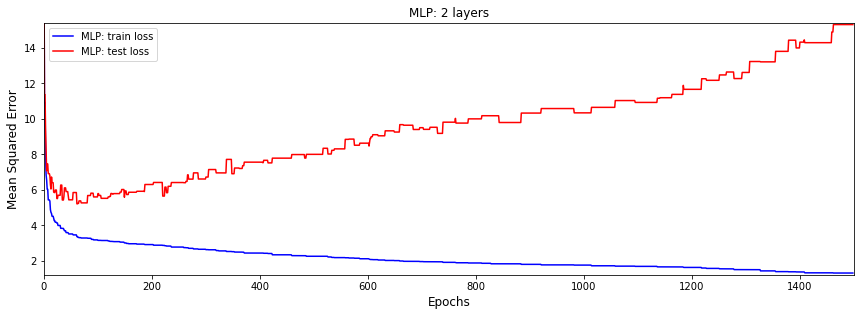

In [25]:
plt.plot(10**np.log10(error_train_min[1:]), color='blue', label='MLP: train loss')
plt.plot(10**np.log10(error_test_min[1:]), color='red', label='MLP: test loss')
plt.xlim(0,N_epoch)
plt.ylim(np.min(error_train_min)-0.1,np.max(error_test_min[5:])+0.1)
plt.legend();
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Mean Squared Error",fontsize=12)
plt.title("MLP: 2 layers",fontsize=12)
plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)

Notre problème initial étant relativement simple, i.e., peu de variables explicatives, il ne parait pas
incohérent que le meilleur modèle MLP soit très simpliste également.